# Code Script for our Analysis

### Install Packages

In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Import bioservices module, to run remote UniProt queries
from bioservices import UniProt

### Read Network Data

In [18]:
# opening the interactome file
file_name= "data\\PathLinker_2018_human-ppi-weighted-cap0_75.txt"
pathLinker_file = open (file_name , 'r')

In [19]:
# reading the header line
header_line = pathLinker_file.readline()
# reading the data lines
data_lines = pathLinker_file.readlines()

In [20]:
header_line

'#tail\thead\tedge_weight\tedge_type\n'

In [21]:
header_line.rstrip().split('\t')[0:3]

['#tail', 'head', 'edge_weight']

### Converting to DataFrame

In [55]:
# looping over the data lines and extracting the tail, head and weight of each edge
weighed_edges_list=[]
for line in data_lines:
    tail,head = (line.split('\t'))[0:2]
    edge_weight = eval((line.split('\t'))[2])
    weighed_edges_list.append((tail , head , edge_weight))

In [23]:
print(f'Our network consists of {len(weighed_edges_list)} protein interactions.')

Our network consists of 612516 protein interactions.


In [24]:
# Create DataFrame
weighted_edges_df = pd.DataFrame(weighed_edges_list, columns =['Tail', 'Head', 'Edge_weight'])
weighted_edges_df

,Tail,Head,Edge_weight
0,Q8TBF5,Q9UKB1,0.311133
1,Q8TBF4,Q15717,0.311133
2,Q8TBF4,P08865,0.311133
3,Q8TBF4,Q02539,0.311133
4,Q8TBF4,Q96J01,0.201461
...,...,...,...
612511,Q17RB8,Q969G2,0.608042
612512,Q17RB8,Q06710,0.181552
612513,Q17RB8,P15374,0.280419
612514,Q17RB8,Q5JST6,0.608042


In [25]:
# calculate the number of unique proteins in the network
unique_tails = weighted_edges_df['Tail'].unique()
unique_heads = weighted_edges_df['Head'].unique()
unique_proteins = list(set(unique_tails).union(set(unique_heads)))

In [16]:
print('Network Observations')
print('-'*100)
print(f" Our network has {len(unique_tails)} unique tails: {unique_tails}")
print('-'*100)
print(f" Our network has {len(unique_heads)} unique heads: {unique_heads}")
print('-'*100)
print(f" Our network has {len(unique_proteins)} unique proteins")
print('-'*100)

Network Observations
----------------------------------------------------------------------------------------------------
 Our network has 17082 unique tails: ['Q8TBF5' 'Q8TBF4' 'Q5MIZ7' ... 'Q7Z739' 'Q17RB8' 'Q3LFD5']
----------------------------------------------------------------------------------------------------
 Our network has 17095 unique heads: ['Q9UKB1' 'Q15717' 'P08865' ... 'Q008S8' 'Q8N4T0' 'Q8IXL9']
----------------------------------------------------------------------------------------------------
 Our network has 17168 unique proteins
----------------------------------------------------------------------------------------------------


As the number of heads is very close to the number of tails, we may assume that the network is balanced. and this assumption can lead to several insights:
    - Network stability: A balanced PPI network is likely to be more stable and less prone to disruption than an imbalanced network.
    - Symmetrical interactions: The equal number of unique tails and heads suggests that the interactions in the network are symmetrical and that proteins are likely to be interacting with each other in a reciprocal manner.
    - Functionality: Proteins in a balanced PPI network are likely to be playing *similar roles* in the network, regardless of their specific interactions.
    - Lack of dominant hub proteins: If a network is balanced, it is less likely to have a *small number* of highly connected hub proteins that dominate the network.
    - Redundancy: A balanced PPI network is likely to have a high degree of redundancy, with many proteins having similar interactions and functional roles.

### Construct Biological Network Graph

In [26]:
# initialize the graph
DG = nx.DiGraph()
DG.add_weighted_edges_from(weighed_edges_list)

In [69]:
# Take a sample of 100 interaction to be visually appealing
sample_DG = nx.DiGraph()
sample_DG.add_weighted_edges_from(weighed_edges_list[:300])

In [71]:
pos = nx.spring_layout(sample_DG)

Text(0.5, 0.98, 'PPI Network Sample')

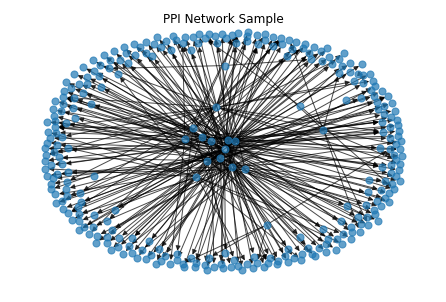

In [76]:
# drawing graph of 100 edges
nx.draw(sample_DG, pos,  node_size=50, edge_color='black', width=1, alpha=0.7)
plt.suptitle("PPI Network Sample")

#### List the acyclic shortest path(s) between two proteins in a text file.

In [61]:
# extracting K-shortest paths between two proteins
weighted_shortest_paths= ([p for p in nx.all_shortest_paths(DG, source="P20933", target="Q15303", weight='weight')])
weighted_shortest_paths

[['P20933', 'Q9Y3A3', 'Q68CZ1', 'P04637', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P04637', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'O15259', 'P22681', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P22681', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q96ST8', 'P46108', 'Q15303'],
 ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P46108', 'Q15303']]

1- Provide the total path score.

In [29]:
# calculating the total shortest path score
total_path_score = nx.shortest_path_length(DG,source="P20933", target="Q15303", weight='weight')
total_path_score

0.6889442

2- Provide the weight of each interaction in the path(s).

In [30]:
# constructing the sub-network of the shortest path
sub_network = nx.DiGraph()
all_paths_edges = []
print('The weight of each interaction in the path(s)')
print("-"*150)
# looping over the shortest paths to be added to the sub-network
for shortest_path in weighted_shortest_paths :
    paths_edges = [tuple([shortest_path[i],shortest_path[i+1],nx.path_weight(DG,([shortest_path[i],shortest_path[i+1]]), weight ='weight')]) for i in range(len(shortest_path)-1)]
    print(paths_edges)
    # add path edges to the new sub-network
    sub_network.add_weighted_edges_from(paths_edges)
    all_paths_edges.append(paths_edges)
    print("-"*150)

The weight of each interaction in the path(s)
------------------------------------------------------------------------------------------------------------------------------------------------------
[('P20933', 'Q9Y3A3', 0.311133), ('Q9Y3A3', 'Q68CZ1', 0.0333391), ('Q68CZ1', 'P04637', 0.0333391), ('P04637', 'Q15303', 0.311133)]
------------------------------------------------------------------------------------------------------------------------------------------------------
[('P20933', 'Q9Y3A3', 0.311133), ('Q9Y3A3', 'Q6ZU80', 0.0333391), ('Q6ZU80', 'P04637', 0.0333391), ('P04637', 'Q15303', 0.311133)]
------------------------------------------------------------------------------------------------------------------------------------------------------
[('P20933', 'Q9Y3A3', 0.311133), ('Q9Y3A3', 'O15259', 0.0333391), ('O15259', 'P22681', 0.0333391), ('P22681', 'Q15303', 0.311133)]
------------------------------------------------------------------------------------------------------------

3- If more than one path, report all the paths.

In [31]:
for i, path in enumerate(weighted_shortest_paths):
    print(f'path{i} is: {path}')

path0 is: ['P20933', 'Q9Y3A3', 'Q68CZ1', 'P04637', 'Q15303']
path1 is: ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P04637', 'Q15303']
path2 is: ['P20933', 'Q9Y3A3', 'O15259', 'P22681', 'Q15303']
path3 is: ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P22681', 'Q15303']
path4 is: ['P20933', 'Q9Y3A3', 'Q96ST8', 'P46108', 'Q15303']
path5 is: ['P20933', 'Q9Y3A3', 'Q6ZU80', 'P46108', 'Q15303']


4- Draw the sub-network formed by these shortest paths.

All shortest paths between protein P20933 & Q15303:


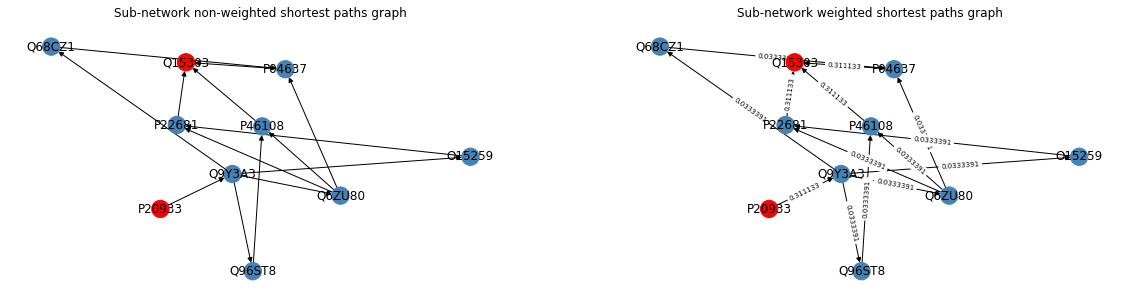

In [32]:
pos = nx.spring_layout(sub_network)
sub_weight_labels = nx.get_edge_attributes(sub_network,'weight')

print(f'All shortest paths between protein P20933 & Q15303:')
two_nodes = ['P20933', 'Q15303']
# coloring the source and target protein nodes
node_col = ['steelblue' if not node in two_nodes else 'red' for node in sub_network.nodes()]

fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
nx.draw(sub_network, pos, with_labels = True, node_color = node_col)
plt.title('Sub-network non-weighted shortest paths graph')

plt.subplot(1, 2, 2)
nx.draw(sub_network, pos, with_labels = True, node_color = node_col)
nx.draw_networkx_edge_labels(sub_network,pos,font_size=7,edge_labels=sub_weight_labels)
plt.title('Sub-network weighted shortest paths graph')

fig.savefig('images\\shortest_paths_subnetwork.png')

In [33]:
# writing the shortrst path and the total path score to a file
shortest_paths_number = len(weighted_shortest_paths)
source = "P20933"
target = "Q15303"
first_line = f"Shortest paths between {source} and {target} Proteins\n\nNumber of shortest paths :{shortest_paths_number}"

shortest_path_file = open ("data\\acyclic_shortest_path.txt",'w')
shortest_path_file.write(first_line)
shortest_path_file.write("\nTotal path score : %f \n\n" %total_path_score)

for idx ,shortest_path in enumerate(weighted_shortest_paths):
    shortest_path_file.write(f"Path {idx} : \n")
    nodes_joined = " > ".join(shortest_path)
    # writing the nodes of each path concatenated
    shortest_path_file.write(f"{nodes_joined} ")
    shortest_path_file.write("\n\n\tTail\tHead\tEdge_weight\n")
    # wriring the edges weights of each path
    for edges in all_paths_edges[idx]:
        shortest_path_file.write(f"\t{edges[0]}\t{edges[1]}\t{edges[2]}\n")

    shortest_path_file.write("\n")
shortest_path_file.close()

### List all the directly connected proteins to a given one protein in a text file.
- Report the degree (number of connections) of this protein in a separate line.
- Provide each connected protein in a line with its corresponding interaction weight.

In [34]:
given_protein = "Q5MIZ7"

In [35]:
successors = [n for n in DG.successors(given_protein)]
print(f'The out Degree for the given protein is {len(successors)} and the proteins where the given protein interact with are:\n{successors}')
out_degree = DG.out_degree(given_protein)

The out Degree for the given protein is 33 and the proteins where the given protein interact with are:
['Q8N490', 'Q53ET0', 'P51648', 'P04629', 'P46379', 'P16104', 'Q99689', 'P62714', 'Q9H3S7', 'Q16719', 'Q86VU5', 'Q96LJ8', 'Q07866', 'P27348', 'Q9NR45', 'P07384', 'P30084', 'O75439', 'Q9H0B6', 'P33176', 'P62829', 'P35557', 'O60610', 'Q53H82', 'O14745', 'Q00839', 'Q13263', 'Q96KP4', 'Q9NY27', 'P60510', 'P21980', 'Q9BZF1', 'Q14103']


In [36]:
predecessors = [n for n in DG.predecessors(given_protein)]
print(f'The in Degree for the given protein is {len(predecessors)} and the proteins that interacts with the given protein are:\n{predecessors}')
in_degree = DG.in_degree(given_protein)

The in Degree for the given protein is 31 and the proteins that interacts with the given protein are:
['P62829', 'Q99689', 'O14745', 'P27348', 'P30084', 'Q86VU5', 'Q14103', 'P04629', 'Q96LJ8', 'Q00839', 'P35557', 'P60510', 'Q13263', 'P07384', 'Q9H3S7', 'Q53H82', 'Q9BZF1', 'O75439', 'O60610', 'P62714', 'Q07866', 'P21980', 'Q9NR45', 'Q96KP4', 'P46379', 'P51648', 'Q9NY27', 'Q9H0B6', 'Q8N490', 'P33176', 'Q16719']


In [37]:
print(f'The total Degree for the given protein is {len(predecessors)+len(successors)} and the proteins that interacts with or the given protein interacts with are:\n{[*predecessors, *successors]}')
all_degree = DG.degree(given_protein)

The total Degree for the given protein is 64 and the proteins that interacts with or the given protein interacts with are:
['P62829', 'Q99689', 'O14745', 'P27348', 'P30084', 'Q86VU5', 'Q14103', 'P04629', 'Q96LJ8', 'Q00839', 'P35557', 'P60510', 'Q13263', 'P07384', 'Q9H3S7', 'Q53H82', 'Q9BZF1', 'O75439', 'O60610', 'P62714', 'Q07866', 'P21980', 'Q9NR45', 'Q96KP4', 'P46379', 'P51648', 'Q9NY27', 'Q9H0B6', 'Q8N490', 'P33176', 'Q16719', 'Q8N490', 'Q53ET0', 'P51648', 'P04629', 'P46379', 'P16104', 'Q99689', 'P62714', 'Q9H3S7', 'Q16719', 'Q86VU5', 'Q96LJ8', 'Q07866', 'P27348', 'Q9NR45', 'P07384', 'P30084', 'O75439', 'Q9H0B6', 'P33176', 'P62829', 'P35557', 'O60610', 'Q53H82', 'O14745', 'Q00839', 'Q13263', 'Q96KP4', 'Q9NY27', 'P60510', 'P21980', 'Q9BZF1', 'Q14103']


In [38]:
protein_predecessors_file = open (f"data\\{given_protein}_predecessors.txt",'w')
protein_predecessors_file.write(f"{given_protein} In Degree = %d \n" %in_degree)
protein_predecessors_file.write("\nTail\tHead\tEdge_weight\n")
for tail in predecessors:
    protein_predecessors_file.write(f"{tail}\t{given_protein}\t{nx.path_weight(DG,(tail,given_protein), weight ='weight')}\n")
protein_predecessors_file.close()

In [39]:
# Saved text file
weighted_edges_df[weighted_edges_df["Head"]==given_protein]

,Tail,Head,Edge_weight
27817,P62829,Q5MIZ7,0.201461
31863,Q99689,Q5MIZ7,0.750000
34520,O14745,Q5MIZ7,0.201461
60461,P27348,Q5MIZ7,0.201461
122329,P30084,Q5MIZ7,0.201461
137890,Q86VU5,Q5MIZ7,0.311133
159380,Q14103,Q5MIZ7,0.311133
160235,P04629,Q5MIZ7,0.311133
195937,Q96LJ8,Q5MIZ7,0.311133
227489,Q00839,Q5MIZ7,0.201461


Conclusion: when in-degree is close to out-degree that can result in stability of overall network topological, thus some studies have suggested that a more stable network may decrease the probability of disease infection by providing more robust connections between proteins, reducing the risk of network failure and disease spread. However, this is not a universal trend and stability in network topology may not always result in decreased disease infection. Further research is needed to fully understand the relationship between network stability, network topology, and disease infection.

#### Given a set of proteins:
- Draw a histogram for the proteins degree.
- Rank these proteins from the highly connected to the least in a text file, where each line is a protein and its corresponding degree.

In [43]:
proteins_set = unique_proteins

In [46]:
#DG.nodes() 
in_degrees = [DG.in_degree(n) for n in proteins_set]
out_degrees = [DG.out_degree(n) for n in proteins_set]
degrees = [DG.degree(n) for n in proteins_set]

# print(f'Corresponding to the given set of proteins\n \n, the in degree is {in_degrees}\n, the out degree is {out_degrees}\n, and the total degree is {degrees}\n')

In [47]:
proteins_degrees = pd.DataFrame(list(zip(proteins_set, in_degrees, out_degrees, degrees)),columns =['Proteins', 'In_Degree' , 'Out_Degree',"Degrees"])
proteins_degrees

,Proteins,In_Degree,Out_Degree,Degrees
0,Q9NX09,17,19,36
1,Q9UIS9,47,45,92
2,P18054,9,9,18
3,Q9HD20,7,7,14
4,Q96DZ5,10,10,20
...,...,...,...,...
17163,P01222,4,3,7
17164,Q15329,18,19,37
17165,Q3SY84,28,28,56
17166,Q9BTV4,37,37,74


In [48]:
sorted_degrees = proteins_degrees.sort_values(by=['Degrees'], ascending=False)
sorted_degrees

,Proteins,In_Degree,Out_Degree,Degrees
6315,P05067,2083,2087,4170
16977,P04629,1989,1961,3950
16130,Q15717,1797,1800,3597
11068,P05412,1531,1521,3052
3551,O14980,1232,1230,2462
...,...,...,...,...
11198,A6NHC0,0,1,1
14988,Q9HA82,1,0,1
11209,Q6J4K2,1,0,1
5714,Q9NTU7,1,0,1


In [49]:
protein_degrees_file = open ("data\\proteins_degrees.txt",'w')
protein_degrees_file.write("Protein\tDegree\n\n")

for idx in sorted_degrees.index:
    protein_degrees_file.write(f"{sorted_degrees['Proteins'][idx]}\t{sorted_degrees['Degrees'][idx]}\n")

protein_degrees_file.close()

In [51]:
sub_proteins_degrees = sorted_degrees.head(10)

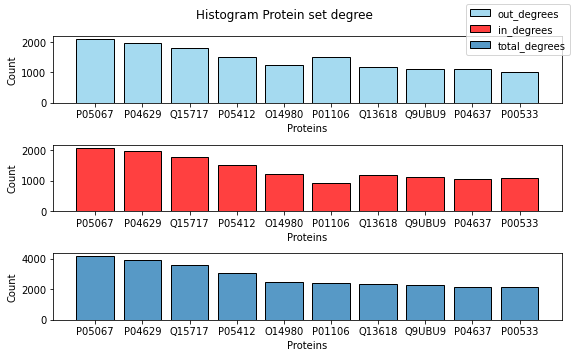

In [54]:
import seaborn as sns
fig, axs = plt.subplots(3, figsize=(8, 5))

sns.histplot(data=sub_proteins_degrees, x="Proteins",  weights=sub_proteins_degrees["Out_Degree"] ,color="skyblue", label="out_degrees" , shrink=.8 , ax=axs[0])

sns.histplot(data=sub_proteins_degrees, x="Proteins", weights=sub_proteins_degrees["In_Degree"], color="red", label="in_degrees" , shrink=.8, ax=axs[1])

sns.histplot(data=sub_proteins_degrees, x="Proteins" , weights=sub_proteins_degrees["Degrees"] , shrink=.8, ax=axs[2], label='total_degrees')

plt.suptitle('Histogram Protein set degree')

fig.legend()
fig.tight_layout()
fig.savefig('images\\histogram_proteins_set')

We notice that P05067 is a hub protein and may be a key scaffold protein (based on its protein complex), and as hub proteins play a central role in the organization and function of the network. The importance of hub proteins can be attributed to several factors, including:
- Modularity: Hub proteins can act as central connectors between different modules or functional units in the network, allowing for effective communication and coordination of cellular processes.
- Robustness: Hub proteins can provide stability to the network by forming multiple interactions with other proteins, making the network less susceptible to failure or perturbations.
- Functionality: Hub proteins are often involved in multiple pathways and functions, making them crucial for the overall function of the cell.
- Evolution: Hub proteins tend to evolve slowly and are conserved across species, suggesting their importance in the evolution and stability of cellular processes.
- Disease: Disruptions in the interactions of hub proteins can have a significant impact on cellular processes and have been implicated in various diseases, such as cancer.

So, our subnetwork is robust, modular, & stable. and if there is any disruptions in the interactions of hub proteins that can result in cancer.

#### Provide a conversion map between the protein UniProt ID and its gene name.
- You can be provided by one protein ID or a set of protein IDs, and then you need to get their corresponding gene names.

In [30]:
# Make a link to the UniProt webservice
service = UniProt()

# Build a query string (try this a test)
query = "P62829"

# Send the query to UniProt, and catch the search result in a variable
result = service.search(query)

# Inspect the result
print(result)

0it [00:00, ?it/s]

Entry	Entry Name	Reviewed	Protein names	Gene Names	Organism	Length
P62829	RL23_HUMAN	reviewed	60S ribosomal protein L23 (60S ribosomal protein L17) (Large ribosomal subunit protein uL14)	RPL23	Homo sapiens (Human)	140


In [31]:
# Make a link to the UniProt webservice
service = UniProt()

gene_names=[]
UniProt_IDs =  proteins_set.copy()

for ID in UniProt_IDs:
    # Send the query to UniProt, and catch the search result in a variable
    result = service.search(ID)
    gene_name=result.split("\t")[-3].split(" ")[0]
    gene_names.append(gene_name)

print(f'Proteins are\n {UniProt_IDs}\n Corresponding genes are {gene_names}')

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Proteins are
 ['P62829', 'Q99689', 'O14745', 'P27348', 'P30084', 'Q86VU5', 'Q14103']
 Corresponding genes are ['RPL23', 'FEZ1', 'SLC9A3R1', 'YWHAQ', 'ECHS1', 'COMTD1', 'HNRNPD']


#### Convert the above graph as an unweighted graph and save it using the adjacency matrix method.

In [32]:
import numpy as np

data = weighted_shortest_paths.copy()

unique_proteins = list(set([protein for sublist in data for protein in sublist]))

adjacency_matrix = np.zeros((len(unique_proteins), len(unique_proteins)), dtype=int)

for sublist in data:
    for i, protein1 in enumerate(sublist[:-1]):
        for j, protein2 in enumerate(sublist[i+1:], i+1):
            protein1_index = unique_proteins.index(protein1)
            protein2_index = unique_proteins.index(protein2)
            adjacency_matrix[protein1_index][protein2_index] = 1
            adjacency_matrix[protein2_index][protein1_index] = 1

print(adjacency_matrix)

[[0 1 1 0 1 0 1 0 1 0]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 0 1 0 1 0]
 [0 1 0 0 0 1 1 0 1 0]
 [1 1 0 0 0 1 1 1 1 0]
 [0 1 0 1 1 0 1 0 1 0]
 [1 1 1 1 1 1 0 1 1 1]
 [0 1 0 0 1 0 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [0 1 0 0 0 0 1 1 1 0]]


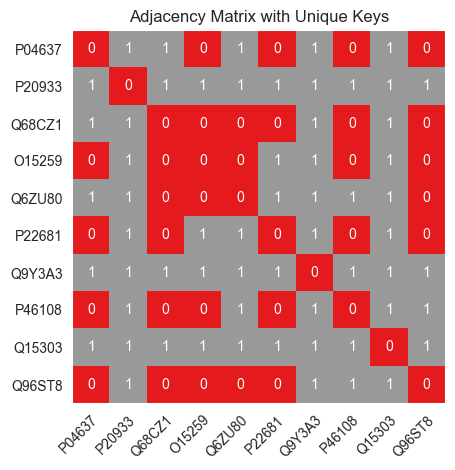

In [72]:
fig, ax = plt.subplots()
im = ax.imshow(adjacency_matrix, cmap='Set1')

ax.set_xticks(np.arange(len(unique_proteins)))
ax.set_yticks(np.arange(len(unique_proteins)))

ax.set_xticklabels(unique_proteins)
ax.set_yticklabels(unique_proteins)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(unique_proteins)):
    for j in range(len(unique_proteins)):
        text = ax.text(j, i, adjacency_matrix[i, j],
                       ha="center", va="center", color="w")
ax.grid(False)
ax.set_title("Adjacency Matrix with Unique Keys")
fig.tight_layout()
fig.savefig('images\\adjacency_matrix.png')

Q9Y3A3 is the hub protein of this sub-network.